# **Report**

Our overall goal in this report and assignment is to become used to Decision Tree Algorithm. To familiarize with decision tree algorithm, we are tasked with implementing a decision tree using the ID3 algorithm and preventing overfitting of our decision tree by pruning.

## Importing necessary libraries and methods

Our first job, of course, is to import the libraries that will be used in the implementation of given assignment 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

# **Part 1**

In the first part, we will work on a classification problem by creating and using decision tree model by using ID3 algorithm. Our objective is to predict whether a patient
is a potential diabetic or not.

### Read csv file into DataFrame

In [ ]:
df = pd.read_csv('/drive/My Drive/Colab Notebooks/BBM409-Assignment-2/diabetes_data_upload.csv')

In [ ]:
df.head(5)

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,Male,No,Yes,No,Yes,No,No,No,Yes,No,Yes,No,Yes,Yes,Yes,Positive
1,58,Male,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,Positive
2,41,Male,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,Positive
3,45,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,Positive
4,60,Male,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Positive


Convert the DataFrame to a NumPy array for future use. 

In [ ]:
df_arr = df.to_numpy()
df_arr

array([[40, 'Male', 'No', ..., 'Yes', 'Yes', 'Positive'],
       [58, 'Male', 'No', ..., 'Yes', 'No', 'Positive'],
       [41, 'Male', 'Yes', ..., 'Yes', 'No', 'Positive'],
       ...,
       [58, 'Female', 'Yes', ..., 'No', 'Yes', 'Positive'],
       [32, 'Female', 'No', ..., 'Yes', 'No', 'Negative'],
       [42, 'Male', 'No', ..., 'No', 'No', 'Negative']], dtype=object)

### Discretization process on continuous attribute "Age"
Before implementing ID3 concept for on attributes in the given dataset, we must ensure that all attributes are discrete.
Given dataset contains a continuous attribute which is called as "Age". For the discretization process of column Age, we created 5 intervals between range of minimum and maximum values. We rescaled values of Age attribute between 0-4.


In [ ]:
age_column = df_arr[:, 0] # Age column
max_age = max(age_column) # maximum value of Age column
min_age = min(age_column) # minimum value of Age column
interval = round((max_age - min_age) / 5) #interval value for discretization

# discretization of Age attribute
df_arr[:, 0] = np.digitize(age_column, list(range(min_age + interval, max_age, interval)))

In [ ]:
df_arr

array([[1, 'Male', 'No', ..., 'Yes', 'Yes', 'Positive'],
       [2, 'Male', 'No', ..., 'Yes', 'No', 'Positive'],
       [1, 'Male', 'Yes', ..., 'Yes', 'No', 'Positive'],
       ...,
       [2, 'Female', 'Yes', ..., 'No', 'Yes', 'Positive'],
       [1, 'Female', 'No', ..., 'Yes', 'No', 'Negative'],
       [1, 'Male', 'No', ..., 'No', 'No', 'Negative']], dtype=object)

### Storing the possible values of each attribute within a dictionary

In [ ]:
name_and_id_zipped = zip(df.columns, np.arange(len(df.columns)))
column_value_dict = {column: np.unique(df_arr[:,column_id]) for column, column_id in name_and_id_zipped}
column_value_dict

{'Age': array([0, 1, 2, 3, 4], dtype=object),
 'Alopecia': array(['No', 'Yes'], dtype=object),
 'Gender': array(['Female', 'Male'], dtype=object),
 'Genital thrush': array(['No', 'Yes'], dtype=object),
 'Irritability': array(['No', 'Yes'], dtype=object),
 'Itching': array(['No', 'Yes'], dtype=object),
 'Obesity': array(['No', 'Yes'], dtype=object),
 'Polydipsia': array(['No', 'Yes'], dtype=object),
 'Polyphagia': array(['No', 'Yes'], dtype=object),
 'Polyuria': array(['No', 'Yes'], dtype=object),
 'class': array(['Negative', 'Positive'], dtype=object),
 'delayed healing': array(['No', 'Yes'], dtype=object),
 'muscle stiffness': array(['No', 'Yes'], dtype=object),
 'partial paresis': array(['No', 'Yes'], dtype=object),
 'sudden weight loss': array(['No', 'Yes'], dtype=object),
 'visual blurring': array(['No', 'Yes'], dtype=object),
 'weakness': array(['No', 'Yes'], dtype=object)}

## Decision Tree ID3
Class of Decision Tree where we define our necessary methods to build a decision tree structure using ID3 concept. 


### Methods:
**get_entropy:** Calculates the entropy of given attribute vector and returns the value of entropy.

**get_information_gain:** Calculates the information gain of given attribute vector and returns its information gain.

**get_max_information_gain:** Returns the attribute which has the maximum gain and its gain value.

**fit:** Places number of columns, attributes and column-values pairs and the root node within our ID3 Model so as to easily predict our test sets using them. 

**id3_algorithm_recr:** Recursively constructs the decision tree node by node with the help of ID3 algorithm.

**single_predict:** Calls single_predict_recr and returns its value.

**single_predict_recr:**Predicts a single attribute vector's target class/type and returns the prediction. 


**predict:** Predicts a full test set's target values using single_predict upon each one of them seperately. At the end returns all of the predictions as a numpy array.

**catalogue_twigs:** Finds all twigs from root to leaves. Each twig is a rule which we obtained from our decision tree.

**catalogue_twigs_recr:** Finds all twigs from given node using recursion.

**prune_tree:** Removes branches of decision tree that do not contribute to the our model to prevent overfitting.




In [ ]:
class DecisionTreeID3:
    """
    The Decision Tree Class where we do the majority of our calculations using ID3 algorithm 
    and its supportive utility functions  
    """
    
    
    class Node:
        """
        The Node Class where we use its instances to store the majority and the most important
        of our tree branch/twig/leaf informations
        """
        
        def __init__(self, attribute, attribute_id, values, max_gain=0.0, most_target="", rule=""):
            self.attribute = attribute
            self.attribute_id = attribute_id
            self.values = values
            self.children = list()
            self.max_gain = max_gain
            self.most_target = most_target
            self.rule = rule
    
    def __init__(self):
        """Constructor of our Decision Tree where we define and initialize our class fields"""
        
        self.root = None
        
        self.all_attributes = None
        self.column_value_dict = None
        self.twigs = list()
        self.rules = dict()
    
    def get_entropy(self, amounts):
        """Entropy calculator method"""
        
        #Take the proportions of all values within the values array
        # p = amount / total_amount
        proportions = np.divide(amounts, np.sum(amounts))
        
        #Take the logarithms of all proportions and save them into a new variable
        # log2(p)
        logs = np.log2(proportions)
        
        #Multiply the proportions with logarithms of those proportions and negate them
        # -p * log2(p)
        pro_times_log = np.multiply(-proportions, logs)
        
        #Sum all of the final equation results to get the entropy
        # entropy = -p1 * log2(p1) - p2 * log2(p2) - p3 * log2(p3)...
        entropy = np.sum(pro_times_log)
        
        return entropy
    
    def get_information_gain(self, arr_section, column_id):
        """Information gain calculator method"""
        
        #Select the column of the attribute we want to work with as well as the target attribute
        sec = arr_section[:,[column_id, -1]]
        
        #Find all of the possible values within our current attribute
        values = np.unique(sec[:,0])

        #Find the amounts of possible resulting labels within the current dataset
        full_result_counts = np.unique(sec[:,1], return_counts=True)[1]
        
        #Calculate the overall entropy of the current tree node
        full_entropy = self.get_entropy(full_result_counts)
        
        information_gain = full_entropy
        
        for value in values: #For each value within the possible values
            
            sec2 = sec[sec[:, 0]==[value]] #Find the dataset section where the value is chosen for our attribute
            
            #Find the amounts of possible resulting labels within the newly found dataset
            uniques2, counts2 = np.unique(sec2[:,1], return_counts=True)
            
            #Calculate the entropy of this particular value
            side_entropy = self.get_entropy(counts2)
            
            #Subtract the resulting gains from our overall gain one by one
            information_gain -= side_entropy*(np.sum(counts2)/np.sum(full_result_counts))
            
        return information_gain #Return the final, overall information gain
        
    def get_max_information_gain(self, arr_section, column_ids):
        """Find the most gain among the possible attribute gains"""
        
        #Prepare a dictionary as a way of easily finding the maximum gain amoung the possible gains
        gains_dict = {id: self.get_information_gain(arr_section, id) for id in column_ids}
        
        #Find the maximum gain's index from our dictionary
        max_key = max(gains_dict,  key=gains_dict.get)
        
        #Return the resulting key and max gain value
        return max_key, gains_dict[max_key]
    
    def fit(self, arr, columns, column_value_dict):
        """Fit and train the given input array by constructing a decision tree using ID3 algorithm"""
        
        #Get the attribute (plus target) amount
        column_count = len(columns)
        
        #Get the names of our attributes (plus target)
        self.all_attributes = columns
        
        #Put the attribute value dictionary within our tree class for easy and safe access
        self.column_value_dict = column_value_dict
        
        #Start constructing the decision tree using ID3 algorithm by putting our tree upon our root node
        self.root = self.id3_algorithm_recr(arr, np.arange(column_count), "")
        
    def id3_algorithm_recr(self, arr, column_ids, rule):
        """Create each branch/twig/leaf of the decision tree by recursively calling itsel while performing the ID3 algorithm"""
        
        #Get the possible target values and their amounts within our dataset
        classes, counts = np.unique(arr[:,-1], return_counts=True)
        
        #If the current dataset only contains a single kind of target within itself, then return a leaf node containing that target
        if classes.shape[0] == 1:
            return self.Node(self.all_attributes[-1], -1, classes[0], rule=rule)
        
        #Else, find the target value that has the greatest amount between possible target values
        most_target_index = np.where(counts == np.amax(counts))[0][0]
        most_target = classes[most_target_index]
        
        #If the attributes we can use currently is zero, then return a leaf node containing the target value with the majority amount
        if column_ids[:-1].shape[0] == 0:
            return self.Node(self.all_attributes[-1], -1, most_target, rule=rule)
        
        #Find the highest gain among the possible attributes; store its index and gain
        best_id, max_gain = self.get_max_information_gain(arr, column_ids[:-1])
        
        #Find the possible values that the best attribute can have
        values = self.column_value_dict[self.all_attributes[best_id]]
        
        #Create a node where its attribute and values are the ones of our best attribute
        #As well as fill the necessary side fields that we will need in the future
        node = self.Node(self.all_attributes[best_id], best_id, values, max_gain, most_target, rule=rule)
        
        #For each possible value within the best attribute
        for value in values:
            
            #Create the next rule that we will put inside this next node
            next_rule = rule + " ^ " + str(node.attribute) + "=" + str(value)
            
            #Find the attributes that are not the same as our best attribute
            column_ids = column_ids[~(column_ids == best_id)]
            
            #Find the dataset section where every value of our best attribute is the value 
            #that we are currently working on within this loop
            value_arr = arr[arr[:,best_id] == value]
            
            #If the resulting dataset section is empty:
            if (value_arr.shape[0] == 0):
                
                #Add a leaf node as the child of this particular node with next rule as its rule
                #And the most abundant target value within our current greater dataset as its target value
                node.children.append(self.Node(self.all_attributes[-1], -1, most_target, rule=next_rule))
            else:
                
                #Else, call this method recursively and add its resulting node as a child to our current node
                node.children.append(self.id3_algorithm_recr(value_arr, column_ids, next_rule))
                
        #Finally return our current node
        return node
    
    def single_predict(self, sample):
        """Predict the final resulting target of a single row sample of our dataset"""
        
        #Simply call our recursive single predict function by calling it with our root node
        #And also our "sample" aka a single patient and their dataset information
        return self.single_predict_recr(sample, self.root)
        
    def single_predict_recr(self, sample, node):
        """Predict the final resulting target of a single row sample of our dataset by recursively exploring our tree"""
        
        #If the current node is a leaf node
        if (node.attribute == "class"):
            #Return the value within this leaf
            #Note: Unlike branches and twigs, the "values" field within leaf nodes only contain a single value, their target
            return node.values
    
        #Find the index of the attribute value within the current node's children
        #that has uses the same value as the attribute value within our single sample
        child_id = np.where(node.values == sample[node.attribute_id])[0][0]
        
        #Use the found index to find the next child node that we will journey towards
        child_node = node.children[child_id]
        
        #Return the recursive result of next child node's single predict function call, ie. explore that child node as well
        return self.single_predict_recr(sample, child_node)
    
    def predict(self, sample_arr):
        """Predict and return the resulting targets of a dataset given to us as input"""
        
        #Create a predictions array where we will store each of our predictions
        #corresponding to a single sample for every sample
        predictions = np.array([])
        
        #For each sample within our given array
        for sample in sample_arr:
            
            #Call the single prediction function and add its result into the predictions array
            predictions = np.append(predictions, self.single_predict(sample))
            
        #Return the final predictions
        return predictions
    
    # Below this point are the methods used within and for the second part (Part 2) of this experiment and report.
    
    def catalogue_twigs(self):
        """Catalogue the twigs within our decision tree by putting the twig nodes within our twigs list.
        It also finds and calculates the rules within our decision tree at the same time"""
        
        #Before each catalogue, empty the insides of twigs and rules so that they may be filled correctly after changes
        self.twigs = []
        self.rules = {}
        
        #Call the recursive cataloguing function by giving it our root node as input
        self.catalogue_twigs_recr(self.root)
    
    def catalogue_twigs_recr(self, node):
        """Recursively explore the decision tree while cataloguing both the twigs and the rules"""
        
        #Find whether the current node is a twig or not
        is_twig = True
        
        #If the current node has no children, ie. it is a leaf
        if (len(node.children) == 0):
            
            #If the value within the leaf is not already within the rules
            if node.values not in self.rules:
                
                #Add this value into the rules dictionary as an empty list
                self.rules[node.values] = list()
                
            #Add the current node's rule into the rules dictionary's current value key's list
            self.rules[node.values].append(node.rule[3:])
            
            #Flag the current node as "not a twig"
            is_twig = False
            
        else: #Else, if this node has children
            
            #For each child within this node's children
            for child in node.children:
                
                #If one of the children is not a leaf
                if (child.attribute != "class"):
                    
                    #Flag the current node as "not a twig"
                    is_twig = False
        
        #If, after all the previous calculations, the node is found to be a twig
        if (is_twig == True):
            
            #Add the current node into the twigs list within our decision tree class
            self.twigs.append(node)
            
            #Return and finish the recursive call of the current function
            return
        
        #For each of the children of the current node
        for child in node.children:
            
            #Call the catalogue twigs function recursively to explore those nodes as well
            self.catalogue_twigs_recr(child)
            
    def prune_tree(self, valid_set):
        """Prune our decision tree by getting rid of our unimportant twigs until we hit an unwanted accuracy decrease"""
        
        #Select the validation attributes and targets
        valid_attrs = valid_set[:,:-1]
        valid_target = valid_set[:,-1]
        
        #Predict the targets of the validation set
        valid_pred = self.predict(valid_attrs)
        
        #Calculate the accuracy of the validation set prediction and store it within last_accuracy
        last_accuracy = accuracy_score(valid_target, valid_pred)
        
        #Iterate indefinetly until we find a pruning attempt that results in a loss of accuracy
        while (True):
            
            #First catalogue the twigs to find every twig after each iteration
            self.catalogue_twigs()
            
            #If there are no twigs, finish iteration
            if (len(self.twigs) == 0):
                break
                
            #Find the twig with the least gain
            min_gain_node = min(self.twigs,  key=lambda twig: twig.max_gain)
            
            #Store its contents within temporary storages
            children_copy = min_gain_node.children
            attr_copy = min_gain_node.attribute
            attr_ind_copy = min_gain_node.attribute_id
            values_copy = min_gain_node.values
            
            #Empty the children of the node, turn it into a leaf 
            #and put the most abundant target the node points towards as its leaf value
            min_gain_node.children = []
            min_gain_node.attribute = dec.all_attributes[-1]
            min_gain_node.attribute_id = -1
            min_gain_node.values = min_gain_node.most_target
            
            #Calculate the current prediction of the validation set using the current iteration of our decision tree
            valid_pred_curr = self.predict(valid_attrs)
            
            #Calculate the current accuracy score of the current predictions
            current_accuracy = accuracy_score(valid_target, valid_pred_curr)
            
            #If the last accuracy greater than current accuracy, ie. if the accuracy decreased
            if(last_accuracy > current_accuracy):
                
                #Then re-insert every stored field's value into our current twig node once again
                min_gain_node.children = children_copy
                min_gain_node.attribute = attr_copy
                min_gain_node.attribute_id = attr_ind_copy
                min_gain_node.values = values_copy   
                
                #Finish the loop iteration
                break
            else:
                #Else, assign the current accuracy into the last accuracy and re-enter the loop
                last_accuracy = current_accuracy

## Displaying Rules
#### **show_rules:** Displays the rules of a selected decision tree model and those rules' total amount

In [ ]:
def show_rules(tree_name, rule_list):
    rule_size = len(rule_list) #Store rule amount

    #Add two brackets to both sides of every rule
    rule_list = map(lambda x: "(" + x + ")", rule_list)

    #Add two new lines and an "or" symbol between each and every rule
    rules_string = ("\n\n∨ ").join(rule_list)

    #Print and display the resulting outputs
    print("*"*50)
    print(tree_name, "Tree's Rules' Size:", rule_size, end="\n\n")
    print(tree_name, "Tree's Rules:", end="\n\n")
    print(rules_string)
    print("*"*50)

## Splitting Dataset and Testing
Our dataset is splitted into two parts which are training set and test set using 5-fold cross validation method. After this split we fit, ie. construct our decision tree using ID3 algorithm. Later, we predict the results of our test set. After storing 5 (or less) misclassified samples for future error analysis, we start calculating our metrics to analyze our results. After calculating these metrics such as, accuracy, precission, recall, f1 scores, we print them out to analyze these results.


In [ ]:
#Split dataset using 5-fold cross validation method
kf = KFold(n_splits=5, shuffle=True)

i = 0
#Store decision tree, F1 score and misclassified pairs as a result of each validation set. 
trees_and_f1_scores = []

#For each different fold of the K-Fold
for train_index, test_index in kf.split(df_arr):

    #Create and initialize the decision tree
    dec = DecisionTreeID3()
    
    #Get our training and test data sets
    train_arr, test_arr = df_arr[train_index], df_arr[test_index]
    
    #Fit/Construct the decision tree with our training dataset
    dec.fit(train_arr, df.columns, column_value_dict)

    #Predict the results of test dataset and store those predictions
    predictions = dec.predict(test_arr[:,:-1])
    
    #Find the wrong predictions within the predictions list
    wrong_prediction_indices = np.where(predictions != test_arr[:,-1])[0]

    #Necessary for displaying misclassified samples
    #few_wrong_prediction_indices stores  at most 5 indices of misclassified samples
    if len(wrong_prediction_indices) < 5:
        few_wrong_prediction_indices = wrong_prediction_indices
    else:
        few_wrong_prediction_indices = wrong_prediction_indices[:5]
    
    #Store the misclassified pairs of test sample and predictions
    misclassified_pairs = list(zip(test_arr[few_wrong_prediction_indices], predictions[few_wrong_prediction_indices]))


    #Construct confusion matrix
    conf_matrix = confusion_matrix(test_arr[:,-1], predictions, labels=['Positive', 'Negative'])
    
    tp = conf_matrix[0,0] #Number of True Positive
    fp = conf_matrix[1,0] #Number of False Positive
    tn = conf_matrix[1,1] #Number of True Negative
    fn = conf_matrix[0,1] #Number of False Negative
    
    #Calculations of classification metrics 

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = (2 * recall * precision) / (recall + precision) 
    
    #Display classification metrics 

    print("Current K = ", i)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1:", f1)
    print("Confusion Matrix\n",conf_matrix)
    print("*"*50)
    
    #Add decision tree, F1 score and misclassified pairs as a result of the test set.
    trees_and_f1_scores.append((dec, f1, misclassified_pairs))
    i += 1
    
#Find the best, ie. the highest f1 scored, tree among our k-folded possible trees
best_tree_and_f1 = max(trees_and_f1_scores, key=lambda x: x[1])

Current K =  0
Accuracy: 0.9615384615384616
Precision: 0.9846153846153847
Recall: 0.9552238805970149
F1: 0.9696969696969696
Confusion Matrix
 [[64  3]
 [ 1 36]]
**************************************************
Current K =  1
Accuracy: 0.9519230769230769
Precision: 0.9344262295081968
Recall: 0.9827586206896551
F1: 0.9579831932773109
Confusion Matrix
 [[57  1]
 [ 4 42]]
**************************************************
Current K =  2
Accuracy: 0.8942307692307693
Precision: 0.9047619047619048
Recall: 0.9193548387096774
F1: 0.912
Confusion Matrix
 [[57  5]
 [ 6 36]]
**************************************************
Current K =  3
Accuracy: 0.9326923076923077
Precision: 1.0
Recall: 0.8955223880597015
F1: 0.9448818897637796
Confusion Matrix
 [[60  7]
 [ 0 37]]
**************************************************
Current K =  4
Accuracy: 0.9711538461538461
Precision: 1.0
Recall: 0.9545454545454546
F1: 0.9767441860465117
Confusion Matrix
 [[63  3]
 [ 0 38]]
**********************************

## **Error Analysis for Classification**


### **Misclassified Samples**


**Below picture is of a previous test we did, stored for analyzation purposes**

Actually it is difficult to find misclassified samples because our ID3 model is well trained. But some reasons may cause misclassification of samples. For example, our training data may include an important number of wrong samples which causes us to construct the decision tree incorrectly, or the single row of test sample we used for this test may be incorrect. The reason of misclassification may be overfitting depending on the distribution of the data in the training set, or it may be underfitting due to the small size of our dataset.

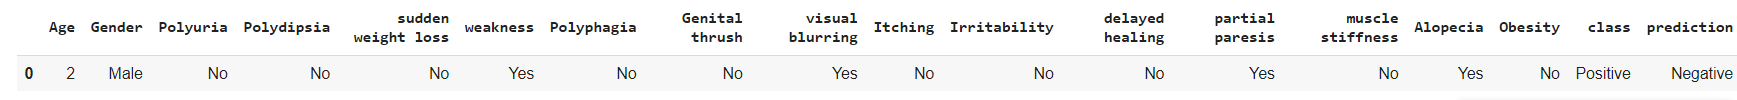

In [ ]:
#Display misclassified samples and their actual classes as a table
misclassified_samples = best_tree_and_f1[2]

misclassified_df = []
for sample in misclassified_samples:
    test_sample = sample[0]
    prediction = sample[1]
    test_sample = np.append(test_sample, prediction)
    misclassified_df.append(test_sample)


cols = list(df.columns.copy())
cols.append("prediction")
pd.DataFrame(misclassified_df, columns=cols)

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class,prediction
0,0,Female,No,No,No,Yes,Yes,No,Yes,No,No,No,No,No,Yes,No,Positive,Negative
1,1,Female,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Positive,Negative
2,1,Female,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Positive,Negative


Above we can see the misclassified samples of our best decision tree. As we talked about in the previous sections, the reason behind these misclassifications may be multiple and hard to pinpoint. But overall, the most likely culprit is the dataset given to us being relatively small or having incorrect samples within. Resulting in wrong predictions from time to time. Yet, it is also worth pointing out that, even with more or less 150 testing samples we used for this test, we only got 3 misclassifed samples (if it were bigger than 5, we would have seen exactly 5), shows us the correctness and usefulness of the algortihm and decision tree we used and made, giving us exceptionally great results.

### **Performance Metrics**

We have five ID3 models constructed with respect to 5-fold cross validation. Our dataset contains 520 samples at first. In each iteration, we have 104 samples for the validation set and 416 samples for the training our model.


#### **Representation of Confusion Matrix**
Clarifying the matrix notation would be a good start to read and comment on confusion matrix and other performance metrics.

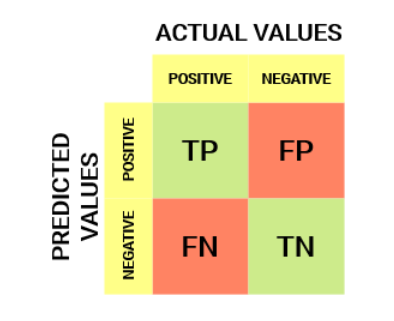

*(Bhandari, 2020)

The target variable has two values: Positive or Negative

The columns represent the actual values of the target variable

The rows represent the predicted values of the target variable

**Performance metrics of each validation set is below.**

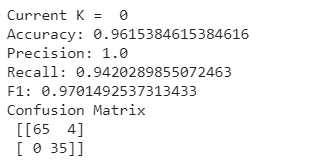

In our first model, precision value gives us the result that all of the correctly predicted cases actually turned out to be positive. This is a rare but possible result stemming from our test case having an exceptionally small number of samples that result in a high probability of homogeneous and similar results.

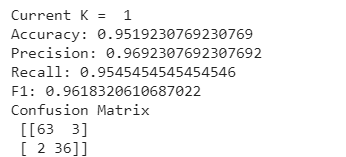

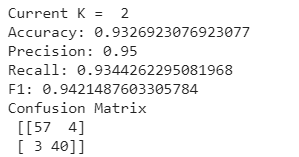

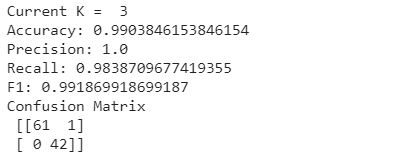

In our fourth model, precision value gives us the result that all of the correctly predicted cases actually turned out to be positive which has the same reasoning behind this outcome as our first fold.

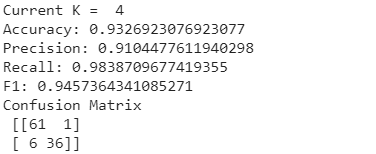

If we make a general comment, the accuracy values of all our models are close to each other and above 93%. This is actually quite satisfactory for us, but if we want to find the decision tree that works best, we should take other performance metrics into account as well because although our accuracy value is quite high, accuracy metric may not be a good measure enough. When we look at the recall values, we get a result between approximately 93% and 98%. Recall value tells us how many of the actual positive cases we were able to predict correctly with our model. According to recall value, our fourth and fifth models which are both has the same recall value give the best results. Precision values of our models are between %91 and %100. Precision value gives us the result that how many of the correctly predicted cases actually turned out to be positive. Our first and fourth models give the best results with respect to precision value. Because precision and recall values are very close to each other, manual calculation may not be the right way to choose the best model. Instead of evaluating these values separately, we can use the F1 score, which is a harmonic mean of these values and captures both the trends in a single value. In the light of this information, we see that our best model, which has the highest accuracy value of 99% and the highest F1 score of 99%, is the 4th model, where K = 3.

***Note that shuffling the dataset before using causes different results. We just picked one sample and commented on its outcomes.***

#### **Show The Best Decision Tree Rules**
Display rules of our best performing decision tree model with respect to classification performance metrics such as accuracy, precision, recall and F1 score. Also show the amount of rules within this best tree, thus, giving us a simple glimpse at its speed. (Since less rules equals to more speed overall when predicting our targets)

In [ ]:
best_tree = best_tree_and_f1[0]
best_tree.catalogue_twigs()
best_positive_rules = best_tree.rules['Positive']

show_rules("Best", best_positive_rules)

**************************************************
Best Tree's Rules' Size: 15

Best Tree's Rules:

(Polydipsia=No ^ Polyuria=No ^ Gender=Female ^ Alopecia=No ^ visual blurring=No ^ Age=1 ^ Irritability=No ^ weakness=No ^ sudden weight loss=No ^ Obesity=Yes)

∨ (Polydipsia=No ^ Polyuria=No ^ Gender=Female ^ Alopecia=No ^ visual blurring=No ^ Age=1 ^ Irritability=No ^ weakness=Yes)

∨ (Polydipsia=No ^ Polyuria=No ^ Gender=Female ^ Alopecia=No ^ visual blurring=No ^ Age=2)

∨ (Polydipsia=No ^ Polyuria=No ^ Gender=Female ^ Alopecia=No ^ visual blurring=No ^ Age=3)

∨ (Polydipsia=No ^ Polyuria=No ^ Gender=Female ^ Alopecia=No ^ visual blurring=No ^ Age=4)

∨ (Polydipsia=No ^ Polyuria=No ^ Gender=Female ^ Alopecia=No ^ visual blurring=Yes)

∨ (Polydipsia=No ^ Polyuria=No ^ Gender=Male ^ Irritability=No ^ Age=1 ^ delayed healing=Yes ^ Genital thrush=No)

∨ (Polydipsia=No ^ Polyuria=No ^ Gender=Male ^ Irritability=Yes ^ Genital thrush=Yes)

∨ (Polydipsia=No ^ Polyuria=Yes ^ Itching=No)

∨ (Po

#### **Show the Sizes of Each Tree's Rules and Compare them to the best of Them**

Below, we can see that each of our different folds resulted in different amounts of rules within their decision trees. Showing us the fact that even slightly different training sets may result in drastically different decision trees that differ greatly in both performance, accuracy and speed (Since with a smaller rule set within a tree, we will get a smaller set of nodes to explore before reaching a conclusion, meaning less rules equals to smaller tree and greater speed overall). 

Also, from below, we can see that our best decision tree has slightly less rules within itself. This fact, however, is circumstantial as with different tests, we saw numerous different outcomes such as the tree with drastically most rules being the best tree etc. So it is hard to come to a definitive conclusion from this single observation alone.

In [ ]:
tree_index = 0
for tree, _, _ in trees_and_f1_scores:
  tree.catalogue_twigs()
  tree_rules = tree.rules['Positive']

  print("Tree No.", tree_index, "Rule Amount:", len(tree_rules))
  tree_index += 1

print()
print("Best Tree Rule Amount:", len(best_positive_rules))

Tree No. 0 Rule Amount: 15
Tree No. 1 Rule Amount: 20
Tree No. 2 Rule Amount: 19
Tree No. 3 Rule Amount: 22
Tree No. 4 Rule Amount: 15

Best Tree Rule Amount: 15


# **Part 2**
In the second part, we will prune our decision tree which is constructed [in the first part of our report](https://colab.research.google.com/drive/1vU7NAzQMq8YZmS4_60gwwf9WwSrUh5eP#scrollTo=cdqB4Lm-u3Z5) to prevent overfitting by shortening the lengths of branches and the tree overall.

In [ ]:
#At the start, we will section off parts of our code into train, test and validation sets

#First, we partition the code into a 60-40 split, with 60% going into train set
#and the rest into a test-validation set symbiosis
train_set, valid_set = train_test_split(df_arr, test_size=0.40, shuffle=True)

#Then we partition validation and test sets from the middle to
#get ourselves a 60-20-20 split of train-validation-test split
valid_set, test_set = train_test_split(valid_set, test_size=0.50, shuffle=True)

#We create and initialize a decision tree
dec = DecisionTreeID3()

#Construct and fit our decision tree with the help of our training data set
dec.fit(train_set, df.columns, column_value_dict)

#Predict the results of the test set with our current iteration of this decision tree
predictions = dec.predict(test_set)

#Store the accuracy result of the initial test
old_accuracy = accuracy_score(test_set[:,-1], predictions)

#Now, catalogue the twigs so that we may find out the rules of our initial tree
dec.catalogue_twigs()

#Store the rules of the tree before prunning operation
rules_before_prune = dec.rules['Positive']

#Prune our tree using our validation dataset
dec.prune_tree(valid_set)

#After prunning, predict the results of test set once again with a pruned tree
predictions = dec.predict(test_set)

#Store the accuracy result of the pruned tree test
new_accuracy = accuracy_score(test_set[:,-1], predictions)

#Catalogue the tree once again to find the final rules of the tree
dec.catalogue_twigs()

#Store the rules of the tree after prunning operation
rules_after_prune = dec.rules['Positive']

### Old/New Accuracy And Rules

With the display of our tests below, we can see that with the help of prunning we are not improving the accuracy of our tree as of yet, (where it actually does increase from time to time which happens at around 25% percent of the time, as we will talk about shortly), but it massively cuts back the rule amount; and, as a result, both tree size (as this means we shortened our branches considerably) and prediction time (as we will need considerably shorter time to get to a final result) gets extremely shorter each time. Thus increasing the speed of our predictions and code considerably. We can see that our pruning cut back the rule amount by more than half this time (from 24 to 10), which may result in an incredible performance increase.

In [ ]:
print("Pre-Pruning Accuracy:", old_accuracy)
print("Post-Pruning Accuracy:", new_accuracy)
print()
print("Rule Count Before Pruning:", len(rules_before_prune))
print("Rule Count After Pruning:", len(rules_after_prune))

Pre-Pruning Accuracy: 0.9519230769230769
Post-Pruning Accuracy: 0.9519230769230769

Rule Count Before Pruning: 24
Rule Count After Pruning: 10


In [ ]:
show_rules("Before Pruning", rules_before_prune)

**************************************************
Before Pruning Tree's Rules' Size: 24

Before Pruning Tree's Rules:

(Polyuria=No ^ Gender=Female ^ Alopecia=No ^ Age=0)

∨ (Polyuria=No ^ Gender=Female ^ Alopecia=No ^ Age=1 ^ Polyphagia=No ^ weakness=No ^ sudden weight loss=No ^ Polydipsia=No ^ Genital thrush=No ^ visual blurring=No ^ Itching=No ^ Irritability=No ^ delayed healing=No ^ partial paresis=No ^ muscle stiffness=Yes)

∨ (Polyuria=No ^ Gender=Female ^ Alopecia=No ^ Age=1 ^ Polyphagia=No ^ weakness=No ^ sudden weight loss=No ^ Polydipsia=No ^ Genital thrush=No ^ visual blurring=No ^ Itching=No ^ Irritability=No ^ delayed healing=No ^ partial paresis=Yes)

∨ (Polyuria=No ^ Gender=Female ^ Alopecia=No ^ Age=1 ^ Polyphagia=No ^ weakness=No ^ sudden weight loss=No ^ Polydipsia=No ^ Genital thrush=No ^ visual blurring=No ^ Itching=No ^ Irritability=No ^ delayed healing=Yes)

∨ (Polyuria=No ^ Gender=Female ^ Alopecia=No ^ Age=1 ^ Polyphagia=No ^ weakness=No ^ sudden weight loss=No

In [ ]:
show_rules("After Pruning", rules_after_prune)

**************************************************
After Pruning Tree's Rules' Size: 10

After Pruning Tree's Rules:

(Polyuria=No ^ Gender=Male ^ Irritability=Yes ^ Polydipsia=No ^ Genital thrush=Yes)

∨ (Polyuria=No ^ Gender=Male ^ Irritability=Yes ^ Polydipsia=Yes)

∨ (Polyuria=Yes ^ Polydipsia=No ^ Itching=No)

∨ (Polyuria=Yes ^ Polydipsia=No ^ Itching=Yes ^ delayed healing=No)

∨ (Polyuria=Yes ^ Polydipsia=No ^ Itching=Yes ^ delayed healing=Yes ^ Gender=Female)

∨ (Polyuria=Yes ^ Polydipsia=No ^ Itching=Yes ^ delayed healing=Yes ^ Gender=Male ^ Obesity=No ^ Age=0)

∨ (Polyuria=Yes ^ Polydipsia=No ^ Itching=Yes ^ delayed healing=Yes ^ Gender=Male ^ Obesity=No ^ Age=1)

∨ (Polyuria=Yes ^ Polydipsia=No ^ Itching=Yes ^ delayed healing=Yes ^ Gender=Male ^ Obesity=No ^ Age=2)

∨ (Polyuria=Yes ^ Polydipsia=No ^ Itching=Yes ^ delayed healing=Yes ^ Gender=Male ^ Obesity=No ^ Age=4)

∨ (Polyuria=Yes ^ Polydipsia=Yes)
**************************************************


### Accuracy Decrease/Increase/No-Change Amounts

Below, we tested our pruning code multiple times using iteration to get a sense of how good pruning is for increasing accuracy, whether the accuracy increase, decrease or not change at all after we prune our decision tree. To do this, for multiple times; we create train, validation and test sets, fit our newly created decision tree, predict the before-prune predictions and find out its before-prune accuracy before storing that accuracy; Then, catalogue the tree's twigs for pruning, after the pruning is complete, we predict the results once again and calculate their latest accuracy and store it as well. After iterating over this process multiple times, we finally iterate over each of the resulting accuracies to calculate whether they increased, decreased or not changed after pruning is completed.

In [ ]:
old_accuracy = []
new_accuracy = []

iter_count = 10000
for i in range(iter_count):
    train_set, valid_set = train_test_split(df_arr, test_size=0.40, shuffle=True)
    valid_set, test_set = train_test_split(valid_set, test_size=0.50, shuffle=True)

    dec = DecisionTreeID3()
    dec.fit(train_set, df.columns, column_value_dict)
    
    predictions = dec.predict(test_set)
    
    old_accuracy.append(accuracy_score(test_set[:,-1], predictions))
    
    dec.catalogue_twigs()
    
    dec.prune_tree(valid_set)

    predictions = dec.predict(test_set)
    new_accuracy.append(accuracy_score(test_set[:,-1], predictions))
    
positive = 0
negative = 0
for i in range(iter_count):
    if (old_accuracy[i] > new_accuracy[i]):
        negative += 1
    elif (new_accuracy[i] > old_accuracy[i]):
        positive += 1

print("The Pruning Counts Where Accuracy Decreased: ", negative)
print("The Pruning Counts Where Accuracy Increased: ", positive)

neuter = iter_count - positive - negative
print("The Pruning Counts Where Accuracy Didn't Change: ", neuter)

The Pruning Counts Where Accuracy Decreased:  2068
The Pruning Counts Where Accuracy Increased:  2557
The Pruning Counts Where Accuracy Didn't Change:  5375


Above, we can clearly see that after ten thousand different tree construction, pruning, prediction iterations, our accuracy of predictions decreased 20% of the time, increased 25% of the time and didn't change 55% of the time. Which is actually an acceptable result since, while the decrease of accuracy is bad, it only does so in a small way that may as well be resulting from our validation set being relatively small and the fact that pruning lessens the overfitting and size of our tree inevitably results in an increase in performance and speed. The fact that our accuracy increases considerably more commonly than its decrease also points us at a similar conclusion where we, demonstrably, not only get better speed and performance but also more commonly get better accuracy after getting rid of overfitting. And with its no-change state being far greater in possibility than the two other possiblities, shows us that the greatest value of this particular pruning algorithm in this particular dataset is in its increases of speed and performance rather than its increases of accuracy which happens less frequently. But then again, it is highly likely that this smaller possibility of accuracy increase is resultant from our considerably small dataset, both for training, validation and test purposes, rather than an inability of accuracy increase of our pruning algorithm, which it actually increases more often than not.

## **References**
Bhandari, A.(2020, April 17). *Everything you should know about confusion matrix for machine learning*. Analytics Vidhya. https://www.analyticsvidhya.com/blog/2020/04/confusion-matrix-machine-learning/